In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import average_precision_score

df = pd.read_csv(r"data.csv")

x = df.head()

print(x)

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [2]:
column_names = list(df.columns.values)

print(column_names)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [3]:
null_values = df.isna().any()

print(null_values)

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool


In [4]:
fraud_distribution = df['isFraud'].value_counts(normalize=True)
print("Fraud distribution:")
print(fraud_distribution)

Fraud distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [5]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['isFraud'], df['isFlaggedFraud'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Contingency table:")
print(contingency_table)
print(f"\nChi-square statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"dof: {dof}")
print(f"expected: {expected}")

Contingency table:
isFlaggedFraud        0   1
isFraud                    
0               6354407   0
1                  8197  16

Chi-square statistic: 11616.665816627796
p-value: 0.0
dof: 1
expected: [[6.35439102e+06 1.59793469e+01]
 [8.21297935e+03 2.06531272e-02]]


In [6]:
# Feature engineering
df['amount_to_oldbalanceOrg'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # Add 1 to avoid division by zero
df['amount_to_newbalanceOrig'] = df['amount'] / (df['newbalanceOrig'] + 1)
df['balance_change_org'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [18]:
X = df.drop(['isFraud', 'isFlaggedFraud','nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

In [19]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [22]:
over = SMOTE(sampling_strategy=0.1)  # Increase minority class to 10% of majority
under = RandomUnderSampler(sampling_strategy=0.5)  # Reduce majority class to be twice the now-increased minority

In [33]:
def tune_model(model, param_dist, X, y):
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                       n_iter=20, cv=3, scoring='average_precision',
                                       n_jobs=-1, random_state=42)
    random_search.fit(X, y)
    return random_search.best_estimator_

In [34]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, -1],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [35]:
# Create pipelines for each model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('model', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('model', xgb.XGBClassifier(scale_pos_weight=1/0.001291))
])

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('model', lgb.LGBMClassifier(class_weight='balanced'))
])

In [37]:
print("Tuning Random Forest...")
rf_tuned = tune_model(rf_pipeline, {'model__' + key: value for key, value in rf_params.items()}, X_train, y_train)

print("Tuning XGBoost...")
xgb_tuned = tune_model(xgb_pipeline, {'model__' + key: value for key, value in xgb_params.items()}, X_train, y_train)

print("Tuning LightGBM...")
lgb_tuned = tune_model(lgb_pipeline, {'model__' + key: value for key, value in lgb_params.items()}, X_train, y_train)


Tuning Random Forest...
Tuning XGBoost...
Tuning LightGBM...
[LightGBM] [Info] Number of positive: 508352, number of negative: 1016704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1525056, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [23]:

#models = {
#    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1),
#    'XGBoost': xgb.XGBClassifier(scale_pos_weight=1/0.001291),  # approximate ratio of negative to positive samples
#    'LightGBM': lgb.LGBMClassifier(class_weight='balanced')
#}
#*/

In [38]:
def evaluate_model(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pred_proba)
    avg_precision = average_precision_score(y, y_pred_proba)
    return precision, recall, avg_precision

In [39]:
for name, model in [('Random Forest', rf_tuned), ('XGBoost', xgb_tuned), ('LightGBM', lgb_tuned)]:
    _, _, avg_precision = evaluate_model(model, X_test, y_test)
    print(f"\n{name}:")
    print(f"Test Average Precision: {avg_precision:.4f}")

# Create and evaluate ensemble
ensemble = VotingClassifier(
    estimators=[('rf', rf_tuned), ('xgb', xgb_tuned), ('lgb', lgb_tuned)],
    voting='soft'
)



Random Forest:
Test Average Precision: 0.9597

XGBoost:
Test Average Precision: 0.9617

LightGBM:
Test Average Precision: 0.9256


[LightGBM] [Info] Number of positive: 508352, number of negative: 1016704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1525056, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Ensemble:
Test Average Precision: 0.9673

Top 10 Important Features:
type_CASH_OUT: 0.0307
oldbalanceDest: 0.0408
type_CASH_IN: 0.0442
newbalanceDest: 0.0600
type_PAYMENT: 0.0632
step: 0.0647
type_TRANSFER: 0.0781
amount: 0.1539
newbalanceOrig: 0.1588
oldbalanceOrg: 0.3052


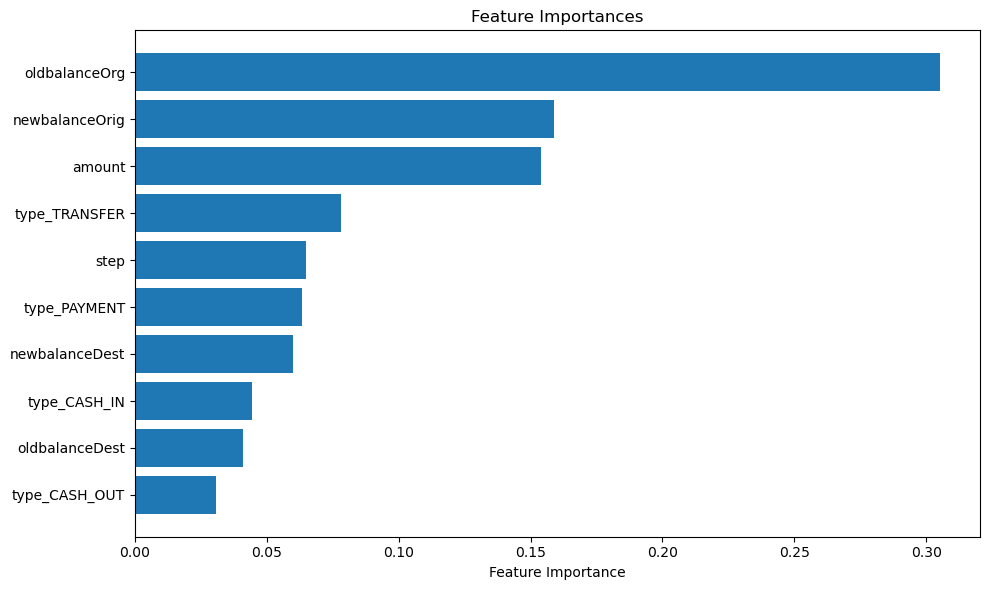

In [41]:
ensemble.fit(X_train, y_train)
_, _, ensemble_avg_precision = evaluate_model(ensemble, X_test, y_test)
print(f"\nEnsemble:")
print(f"Test Average Precision: {ensemble_avg_precision:.4f}")

# Feature importance (for Random Forest)
feature_importance = rf_tuned.named_steps['model'].feature_importances_
feature_names = (numeric_features.tolist() + 
                 rf_tuned.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

sorted_idx = np.argsort(feature_importance)
print("\nTop 10 Important Features:")
for idx in sorted_idx[-10:]:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(sorted_idx[-10:])), feature_importance[sorted_idx[-10:]])
plt.yticks(range(len(sorted_idx[-10:])), [feature_names[i] for i in sorted_idx[-10:]])
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [26]:
results = {}
for name, model in models.items():
    # Create a pipeline with preprocessing, SMOTE, undersampling, and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('over', over),
        ('under', under),
        ('model', model)
    ])
    
    # Use stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        pipeline.fit(X_fold_train, y_fold_train)
        precision, recall, avg_precision = evaluate_model(pipeline, X_fold_val, y_fold_val)
        fold_results.append(avg_precision)
    
    results[name] = {
        'Cross-val Avg Precision': np.mean(fold_results),
        'Cross-val Std Precision': np.std(fold_results)
    }
    
    # Final evaluation on test set
    pipeline.fit(X_train, y_train)
    precision, recall, avg_precision = evaluate_model(pipeline, X_test, y_test)
    results[name]['Test Avg Precision'] = avg_precision

[LightGBM] [Info] Number of positive: 406682, number of negative: 813364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1220046, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 406682, number of negative: 813364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1220046, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> inits

In [ ]:
# Print results
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Random Forest:
Cross-val Avg Precision: 0.9455
Cross-val Std Precision: 0.0060
Test Avg Precision: 0.9496

XGBoost:
Cross-val Avg Precision: 0.7075
Cross-val Std Precision: 0.3526
Test Avg Precision: 0.9539

LightGBM:
Cross-val Avg Precision: 0.8952
Cross-val Std Precision: 0.0969
Test Avg Precision: 0.9252
